In [1]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop

## Initial setup

In [251]:
N_NODES = 50
N_EDGES = 40
K = 10
theta = 0.99
edges_random = np.random.beta(2, 8, (N_NODES, N_NODES))
edges_random_dis = -np.log(edges_random)

In [234]:
edges_random.max()

0.7845941170483086

Text(0.5, 1.0, 'Histogram of transition probabilities')

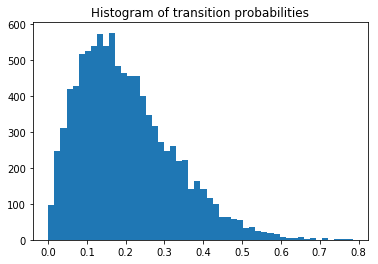

In [235]:
plt.hist(edges_random.reshape(-1), bins=50)
plt.title("Histogram of transition probabilities")

Text(0.5, 1.0, 'Histogram of transition probabilities')

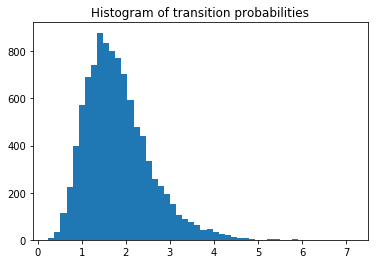

In [236]:
plt.hist(edges_random_dis.reshape(-1), bins=50)
plt.title("Histogram of transition probabilities")

In [260]:
def dijkstra_search(edges_proba, start, end):
    """ Dijkstra algorithm for finding shortest path on a graph defined by
    its weight matrix. 
    
    Args:
        - edges_proba: ndarray of shape (n_nodes, n_nodes) with
          probabilities
        - start: start node
        - end: end node
        
    Returns:
        - path: list of node of shortest path
        - cost: total cost of the path
    """
    weights = -np.log(edges_proba)
    queue = []
    heappush(queue, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    items = set(range(N_NODES))

    while len(queue):
        current = heappop(queue)[1]

        if current == end:
            break

        for next_item in items.difference({current}):
            new_cost = cost_so_far[current] + weights[current, next_item]
            if next_item not in cost_so_far or new_cost < cost_so_far[next_item]:
                cost_so_far[next_item] = new_cost
                priority = new_cost
                heappush(queue, (priority, next_item))
                came_from[next_item] = current

    cursor = end
    path = []
    while cursor != start:
        path.append(cursor)
        cursor = came_from[cursor]
    path.append(start)

    return path[::-1], np.exp(-cost_so_far[end])

In [261]:
dijkstra_search(edges_random, 0, 1)

([0, 1], 0.3823058945892905)

In [262]:
alls = [dijkstra_search(edges_random, 0, i) for i in range(N_NODES)]

In [263]:
alls

[([0], 1.0),
 ([0, 1], 0.3823058945892905),
 ([0, 2], 0.20249674225607592),
 ([0, 3], 0.4138384299978841),
 ([0, 4], 0.3707408178591732),
 ([0, 24, 5], 0.1642268392804828),
 ([0, 20, 6], 0.19017042851939456),
 ([0, 41, 7], 0.21527120804615532),
 ([0, 41, 8], 0.18896365318637406),
 ([0, 9], 0.14664320762060484),
 ([0, 10], 0.20661753515122971),
 ([0, 23, 11], 0.16914884452525059),
 ([0, 12], 0.3845862581774936),
 ([0, 13], 0.3145854417646683),
 ([0, 23, 14], 0.15382746945289474),
 ([0, 1, 15], 0.12915891058216533),
 ([0, 4, 16], 0.19785224351582678),
 ([0, 26, 17], 0.11815625781284628),
 ([0, 24, 18], 0.23282006823968943),
 ([0, 19], 0.1345141117275254),
 ([0, 20], 0.3924988680928669),
 ([0, 21], 0.21134138471901104),
 ([0, 22], 0.22744556268908805),
 ([0, 23], 0.3817028589850833),
 ([0, 24], 0.4573795280948644),
 ([0, 25], 0.1470616160695527),
 ([0, 26], 0.34027682072856097),
 ([0, 27], 0.20552661047290618),
 ([0, 20, 28], 0.15012439703002106),
 ([0, 29], 0.18612631546942957),
 ([0, 30

In [199]:
mip(0, 4)

([0, 4], 0.21987461693731403)

In [266]:
S = np.random.choice(range(N_NODES), size=K)

def mip(u, v):
    """ Maximum influence path function (or shortest
    path in the graph)
    """
    return dijkstra_search(edges_random, u, v)

def pp(u, v):
    
    return dijkstra_search(edges_random, u, v)[1]

def miia(v, theta):
    """ Maximum Influence In-Arborescence funtion
    All the paths to v with propagation probability
    above theta
    """
    u_list = []
    for u in range(N_NODES):
        if v == u: continue
        path, score = mip(u, v)
        if score > theta:
            u_list.append(path)
    return u_list

def mioa(u, theta):
    """ Maximum Influence Out-Arborescence funtion
    All the paths from u with propagation probability
    above theta
    """
    v_list = []
    for v in range(N_NODES):
        if v == u: continue
        path, score = mip(u, v)
        if score > theta:
            v_list.append(path)
    return v_list

In [267]:
miia(8, 0.3)

[[5, 8],
 [14, 8],
 [19, 8],
 [21, 8],
 [27, 8],
 [31, 8],
 [33, 8],
 [35, 8],
 [39, 8],
 [41, 8],
 [49, 8]]

In [269]:
def in_neighbors(u, miia):
    result_set = []
    for path in miia:
        if u in path and path[0] != u:
            result_set.append(path[path.index(u) - 1])
    return result_set

In [344]:
def hsh(i, lst):
    return int( str(hash(repr(lst))) + str(hash(i)))
    
def ap_base(u, S, miia_v_theta):
    n_in = in_neighbors(u, miia_v_theta)
    if u in S:
        return 1.
    elif not len(n_in):
        return 0.
    else:
        base = 1
        for in_neighbor in n_in:
            base *= (1 - ap_base(in_neighbor, S, miia_v_theta)*pp(in_neighbor, u))
        return 1 - base
    
def ap(u, S, miia_v_theta, cache={}):
    n_in = in_neighbors(u, miia_v_theta)
    if u in S:
        return 1.
    elif not len(n_in):
        return 0.
    else:
        base = 1
        for in_neighbor in n_in:
            if hsh(in_neighbor,miia_v_theta) in cache:
                p = cache[hsh(in_neighbor,miia_v_theta)]
            else:
                p =  ap(in_neighbor, S, miia_v_theta, cache)
                cache[hsh(in_neighbor,miia_v_theta)] = p
            base *= (1 - p*pp(in_neighbor, u))
        return 1 - base


In [324]:
# Attempt to linearize the ap calculation
def ap_linear(u, S, miia_v_theta):
    n_in = in_neighbors(u, miia_v_theta)
    if u in S:
        return 1.
    elif not len(n_in):
        return 0.
    else:
        aps = {}
        for path in miia_v_theta:
            if u in path:
                
            ap(in_neighbor, S, miia_v_theta)
        base = 1
        for in_neighbor in n_in:
            base *= (1 - ap(in_neighbor, S, miia_v_theta)*pp(in_neighbor, u))
        return 1 - base


IndentationError: expected an indented block (<ipython-input-324-07a0c93b3796>, line 12)

In [352]:
sum(ap(i, S, miia(i, 0.3)) for i in range(N_NODES))

30.017359723104146

In [256]:
from tqdm import tqdm_notebook as tqdm

In [356]:
def naive_greedy_algorithm(n_source):
    s = []

    for k in tqdm(range(n_source)):
        max_influence = 0
        max_node = 0
        for node in tqdm(range(N_NODES)):
            if not node in s:
                influence = sum(ap(i, s + [node], miia(i, 0.4)) 
                                for i in range(N_NODES))
            if influence > max_influence:
                max_node = node
                max_influence = influence
        s.append(max_node)
    
    return s

In [357]:
naive_greedy_algorithm(2)

[0, 1]